## Autoencoder template

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [77]:
device = torch.device("cuda")

## get DATA

In [65]:
def int2onehot(x, n_class):
    ret = torch.zeros(n_class)
    ret[x] = 1
    return ret
int2onehot(3, 10)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [87]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

def int2onehot(x, n_class):
    ret = torch.zeros(n_class)
    ret[x] = 1
    return ret
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
dir_s = '/home/bwlee/data'
train_set = dset.MNIST(root=dir_s, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=dir_s, train=False, transform=trans, download=True)
# change 2D to 1D for MLP
# train_set
# [(tensor(batch, channel, x, y), label_one_hot)]
# train_set2
# [(tensor(batch, channel, x*y), label_one_hot)] 
n_class = 10
train_set2, test_set2 = [], []
for data in train_set:
    #train_set2.append([data[0].view(1,-1), int2onehot(data[1], n_class)])
    train_set2.append([data[0].view(-1), data[1]])
for data in test_set:
    #test_set2.append([data[0].view(1,-1), int2onehot(data[1], n_class)])
    test_set2.append([data[0].view(-1), data[1]])
    
batch_size = 512
# train_loader, test_loader has form of [data_batch, tgt_batch]
# data_batch in [batch, channel, x, y]
# data_batch in [batch]
train_loader = torch.utils.data.DataLoader(
    dataset=train_set2,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set2,
    batch_size=batch_size,
    shuffle=False
)

In [88]:
print(test_set[1][0].size())
print(test_set[1][1])
print(len(test_set))
print(test_set2[1][0].size())
print(test_set2[1][1])
print(len(test_set2))

torch.Size([1, 28, 28])
2
10000
torch.Size([784])
2
10000


In [89]:
for i, data in enumerate(test_loader):
    if i>0: break
    print(data[0].size())
    print(data[1].size())
    print(data[0][:3])
    print(data[1][:3])

torch.Size([512, 784])
torch.Size([512])
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]])
tensor([7, 2, 1])


In [82]:
def get_MLP(n_hiddens, activation=nn.ReLU(), dropout=0.1):
    def get_a_layer(n_in, n_out, activation, dropout):
        seq = [nn.Dropout(dropout), nn.Linear(n_in, n_out),
                activation]
        return seq
    layers = [get_a_layer(n_in, n_out, activation, dropout) for 
              n_in, n_out in zip(n_hiddens, n_hiddens[1:])]
    layers = [ x for xs in layers for x in xs ]
    return nn.Sequential(*layers)

In [128]:
class Model(nn.Module):
    def __init__(self, model=None, loss=None, 
                 optimizer=None):
        super(Model, self).__init__()
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
    
    def run_batch(self, i_batch, data):
        self.optimizer.zero_grad()
        data_in, tgt = data
        data_in = data_in.to(device)
        tgt = tgt.to(device)
        out = self.model(data_in)
        loss = self.loss(out, tgt)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().item()
    
    def run_train(self, n_epoch, data):
        self.model.train()
        for i_epoch in range(n_epoch):
            loss = 0
            n_batch = len(data)
            for i_batch, data_batch in enumerate(data):
                loss_temp = self.run_batch(i_batch, data_batch)
                loss += loss_temp
                #print(i_batch, loss_temp)
            loss /= 1.0*n_batch
            print('epoch', i_epoch, 'loss', loss)
            
    def run_eval(self, data):
        self.model.eval()
        loss = 0
        for i_batch, data_batch in enumerate(data):
            data_in, tgt = data_batch
            out = self.model(data_in)
            loss += self.loss(out, tgt).detach().cpu()
        loss /= 1.0*i_batch
        return out, loss

In [129]:
class Autoencoder(Model):
    def __init__(self, model=None, loss=None, 
                 optimizer=None):
        super(Autoencoder, self).__init__(model, loss, optimizer)
    
    def run_batch(self, i_batch, data):
        self.optimizer.zero_grad()
        data_in, _ = data
        data_in = data_in.to(device)
        out = self.model(data_in)
        loss = self.loss(out, data_in)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().item()

In [117]:
model = Model()

## TEST

In [28]:
mlp = get_MLP([100, 200, 50])

In [29]:
mlp

Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=100, out_features=200, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): ReLU()
)

### Classifier example

In [ ]:
dim_mnist = 784

encoder = get_MLP([784, 300, 100, 10])
#decoder = get_MLP([100, 300, 784])
#ae_model = nn.Sequential(encoder, decoder)
encoder = encoder.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder.parameters())
classifier = Model(model=encoder, 
                loss=loss, optimizer=optimizer)
classifier.run_train(20, train_loader)

### Autoencoder example

In [149]:
dim_mnist = 784
#dims = [784, 300, 300]
dims = [784, 128, 64, 32]
encoder = get_MLP(dims)
decoder = get_MLP(list(reversed(dims)))
ae_model = nn.Sequential(encoder, decoder)
ae_model = ae_model.to(device)

loss = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters())
ae = Autoencoder(model=ae_model, 
                loss=loss, optimizer=optimizer)
ae.run_train(100, train_loader)

epoch 0 loss 0.2322752343143447
epoch 1 loss 0.22990058551905518
epoch 2 loss 0.2283804662904497
epoch 3 loss 0.22732309037345952
epoch 4 loss 0.22628441263558502
epoch 5 loss 0.22542902258998257
epoch 6 loss 0.22490213028455186
epoch 7 loss 0.22449463138640938
epoch 8 loss 0.22415425236952508
epoch 9 loss 0.22393219248723176
epoch 10 loss 0.22373630396895489
epoch 11 loss 0.22358890913300594
epoch 12 loss 0.22351123051623167
epoch 13 loss 0.22343937332852412
epoch 14 loss 0.2233239821458267
epoch 15 loss 0.22321504506014161
epoch 16 loss 0.2231390248920958
epoch 17 loss 0.2230879717459113
epoch 18 loss 0.22299345658492234
epoch 19 loss 0.2229018664713633
epoch 20 loss 0.22285204052419985
epoch 21 loss 0.22276294913332342
epoch 22 loss 0.22274049851348846
epoch 23 loss 0.2227040601231284
epoch 24 loss 0.22265091146958077
epoch 25 loss 0.22261153767674657
epoch 26 loss 0.22257847200005743
epoch 27 loss 0.22251498105667405
epoch 28 loss 0.2224659534581637
epoch 29 loss 0.2224415404311681

6


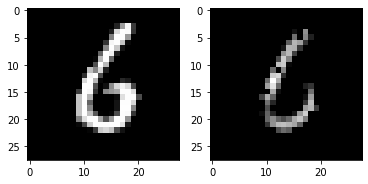

In [148]:
import matplotlib.pyplot as plt


for i_batch, data_batch in enumerate(test_loader):
    if i_batch > 0: 
        break
    with torch.no_grad():
        data_in, tgt = data_batch
        ii = 50
        #data_in0 = data_in[:1]
        data_in0 = data_in[ii:ii+1]
        data_in0 = data_in0.to(device)
        data_in1 = data_in0.cpu().squeeze(0).view(28,28).numpy()
        tgt0 = tgt[ii]
        out = ae.model(data_in0)
        out = out.cpu()
        out = out.squeeze(0)
        out = out.view(28,28).numpy()
        plt.subplot(1,2,1)
        plt.imshow(data_in1, cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(out, cmap='gray')
        print(tgt0.item())